 # Fetching activations from a pretrained model

In [1]:
import os
from functools import partial
from pathlib import Path
from typing import Union

import einops as eo
import git
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from circuitsvis.attention import attention_heads
from transformers import AutoModelForCausalLM, AutoTokenizer

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

rc_fonts = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [r"\usepackage{libertine}", r"\usepackage[libertine]{newtxmath}", r"\usepackage{inconsolata}"]
    ),
}
mpl.rcParams.update(rc_fonts)
plt.rcParams.update(rc_fonts)
sns.set_theme(style="white")

 ### Functions for loading model and fetching activations

In [3]:
def load_model_tokenizer(model_name: str):
    """Load a pretrained model and tokenizer from huggingface.

    Args:
        model_name: The name of the pretrained model to load.

    Returns:
        model: The loaded model.
        tokenizer: The loaded tokenizer.
    """
    model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    tokenizer.pad_token = tokenizer.eos_token
    model.eval()
    return model, tokenizer

In [4]:
def seqlogprob(input_ids, outputs, batch_size, pad_token_id):
    logits = outputs.logits[..., :-1, :].contiguous()
    labels = input_ids[..., 1:].contiguous()

    # compute log probabilities
    log_probs = torch.nn.functional.log_softmax(logits, dim=-1)

    # get per-token probability
    token_log_probs = torch.gather(log_probs, 2, labels.unsqueeze(-1)).squeeze(-1)

    if batch_size > 1:
        # mask padding tokens
        token_log_probs.masked_fill_(labels == pad_token_id, 0.0)

    # sum log probabilities
    return token_log_probs.sum(dim=1)

In [5]:
def compare_blimp(scores):
    first = scores[::2]
    second = scores[1::2]
    # Compare pairs
    return first >= second

In [6]:
def fetch_attention_scores(model, tokenizer, text: Union[list[str], str], layers: list):
    """
    Remember that Q is for the destination tokens, and K is for the source tokens.
        -> Attention moves information from previous (source) tokens, to the current (destination) token.

    For each attention score, the ROW_IDX = DESTINATION (current token)
    """
    if isinstance(text, str):
        # Batch size of 1
        text = [text]

    # Tokenize the input text with padding to the longest sequence in the batch
    tokenized = tokenizer(text, padding=True, return_tensors="pt", return_offsets_mapping=True)

    # Get the individual tokens from the offsets
    tokens = [
        [text[sample_idx][i:j] for i, j in offsets]
        for sample_idx, offsets in enumerate(tokenized["offset_mapping"])
    ]

    # setup hooks
    save_ctx = {}

    def save_attention_hook(self, inputs, output, layer_num):
        input = inputs[0]

        bsz, seq_len, _ = input.shape

        # Unpack inputs and get query and key states
        _queries, _keys = self.q_proj(input), self.k_proj(input)

        # reshape for multihead attn
        queries = _queries.view(bsz, seq_len, self.n_heads, self.head_dim)
        keys = _keys.view(bsz, seq_len, self.n_kv_heads, self.head_dim)

        queries, keys = self.rope(queries, keys, 0)

        # now becomes [bsz, self.n_heads, seq_len, self.head_dim]
        queries = queries.transpose(1, 2)
        keys = keys.transpose(1, 2)

        apply_gqa = self.n_rep > 1
        if apply_gqa:
            keys = keys.repeat_interleave(self.n_rep, dim=-3)

        # Calculate attention scores: [batch_size, n_heads, seq_len, seq_len]
        attention_scores = torch.matmul(queries, keys.transpose(-1, -2))

        # Scale attention scores
        attention_scores = attention_scores / np.sqrt(self.head_dim)

        # Apply attention mask if needed
        attention_mask = tokenized.get("attention_mask", None)

        if attention_mask is not None:
            # Create a mask in the correct shape for broadcasting
            # attention_mask: [batch_size, seq_len] → [batch_size, 1, seq_len, seq_len] lower triangle only
            new_mask = []
            for row in attention_mask:
                num_els = torch.sum(row)
                tot_els = len(row)
                pad = tot_els - num_els
                row_mask = torch.tril(torch.ones(num_els, num_els))
                if pad > 0:
                    row_mask = F.pad(row_mask, (0, pad, 0, pad))

                new_mask.append(row_mask)

            mask = torch.stack(new_mask).unsqueeze(1)

            attention_scores = attention_scores.masked_fill(mask == 0, float("-inf"))

        attention_scores = torch.softmax(attention_scores, dim=-1)

        # Store the attention scores (without softmax)
        save_ctx[layer_num] = attention_scores.detach()

    # Register hooks
    handles = []
    for layer_idx in layers:
        handles.append(
            model.pico_decoder.layers[layer_idx].attention.register_forward_hook(
                partial(save_attention_hook, layer_num=layer_idx)
            )
        )

    # Run through model
    with torch.inference_mode():
        outputs = model(input_ids=tokenized["input_ids"], attention_mask=tokenized["attention_mask"])

    # Remove hook handles from model
    for handle in handles:
        handle.remove()

    seqprob = seqlogprob(tokenized["input_ids"], outputs, len(text), tokenizer.pad_token_id)

    attention_scores_list = []
    tokens_list = []

    for sample_idx, token in enumerate(tokens):
        num_tokens = tokenized["attention_mask"][sample_idx].sum().item()

        # Collect attention patterns for this sample
        sample_scores = []
        for layer_idx in layers:
            # Extract attention pattern for this sample, focusing on real tokens only
            pattern = save_ctx[layer_idx][sample_idx, :, :num_tokens, :num_tokens]
            sample_scores.append(pattern)

        stacked_patterns = torch.stack(sample_scores, dim=0).numpy()

        attention_scores_list.append(stacked_patterns)
        tokens_list.append(token[:num_tokens])

    return tokens_list, attention_scores_list, seqprob

In [7]:
text_batch = [
    "Only Bill would ever complain.",
    "Even Bill would ever complain.",
    "Only Grace ever reveals Janice.",
    "Even Grace ever reveals Janice.",
]

In [8]:
models = {
    r"\texttt{pico-relora}": {
        "repo_url": "https://huggingface.co/yuvalw/pico-relora-tiny-v2-sn",
        "commit_hash": "f567508a0d79eb738a23a117a6753650a9969405",
        "clone_dir": Path("../runs/rem-relora-tiny-20k"),
    },
    r"\texttt{pico-decoder}": {
        "repo_url": "https://huggingface.co/pico-lm/pico-decoder-tiny",
        "commit_hash": "9c866480418eeeb9946b0aaf4318bcdde46db83f",
        "clone_dir": Path("../runs/rem-decoder-tiny-20k"),
    },
}

In [9]:
for d in models.values():
    if not d["clone_dir"].exists():
        repo = git.Repo.clone_from(d["repo_url"], d["clone_dir"])
    else:
        repo = git.Repo(d["clone_dir"])

    repo.git.checkout(d["commit_hash"])

In [26]:
for mname in models:
    model, tokenizer = load_model_tokenizer(models[mname]["clone_dir"])
    models[mname]["model"] = model
    models[mname]["tokenizer"] = tokenizer

In [27]:
# Example usage
all_att_scores = {}
extra = {}
tokens = []
for mname in models:
    model = models[mname]
    tokens, att_patts, probs = fetch_attention_scores(
        model["model"], model["tokenizer"], text_batch, layers=list(range(12))
    )
    all_att_scores[mname] = att_patts
    extra[mname] = {
        "probs": probs,
        "blimp": compare_blimp(probs),
    }

In [28]:
# transform att_patts to dataframe
def _get_att_patt_data():
    for mname, att_patts in all_att_scores.items():
        for sent_idx, att_patt in enumerate(att_patts):
            # remember that rows are the destination index that wants info from other tokens
            # source tokens are being attended to
            for (layer, head, dst_idx, src_idx), score in np.ndenumerate(att_patt):
                if dst_idx >= src_idx:  # lower triangle only
                    yield (mname, sent_idx, layer, head, dst_idx, src_idx, score)


att_patt_df = pd.DataFrame(
    _get_att_patt_data(),
    columns=["Model", "SentNum", "Layer", "Head", "Destination Token", "Source Token", "Score"],
)

In [29]:
sent = 0
attn = eo.rearrange(all_att_scores[r"\texttt{pico-relora}"][sent], "l h dst src -> (l h) dst src")
names = [f"L{l} H{h}" for l in range(12) for h in range(12)]
vis = attention_heads(
    tokens=tokens[sent], attention=attn, max_value=1.0, min_value=0.0, attention_head_names=names
)
# L3H10, L4H0, L5H5, L9H7
vis

In [ ]:
def filter_df(df: pd.DataFrame, sent_nums: tuple[int], layer: int, head: int):
    mask = (df["Layer"] == layer) & (df["Head"] == head) & df["SentNum"].isin(sent_nums)
    return df[mask]

In [82]:
def comparison_plot(
    *,
    sent_pair: int,
    layer: int,
    head: int,
    filename: str,
    show_bar=False,
    font_scale=1.9,
    height=8,
    aspect=1.2,
):
    font_scale = font_scale

    sns.set_theme(font_scale=font_scale, rc={"axes.grid": "True", "axes.grid.which": "both"})
    g = sns.FacetGrid(
        data=filter_df(att_patt_df, (sent_pair * 2, sent_pair * 2 + 1), layer=layer, head=head),
        col="SentNum",
        row="Model",
        height=height,
        aspect=aspect,
        sharey=False,
        sharex=False,
        margin_titles=False,
    )

    def plot_heatmap(data: pd.DataFrame, **kwargs):
        # Create a pivot table for the heatmap
        sent_num = data["SentNum"].iloc[0]
        pivot_data = data.pivot(index="Destination Token", columns="Source Token", values="Score")
        pivot_data.sort_index(inplace=True)

        key_tokens = kwargs.get("key_tokens", "auto")
        if isinstance(key_tokens, int):
            key_tokens = (key_tokens,)
        elif key_tokens == "auto":
            key_tokens = [
                idx
                for idx, (t1, t2) in enumerate(
                    zip(tokens[sent_num], tokens[sent_num + (-1) ** (sent_num % 2)])
                )
                if t1 != t2
            ]

        labels = [
            f"{token} ({idx})" if idx not in key_tokens else rf"\textbf{{{token} ({idx})}}"
            for idx, token in enumerate(tokens[sent_num])
        ]

        def custom_fmt(x):
            rnd = round(x, 5)
            if rnd == 1:
                return "1"
            if rnd == 0:
                return "0"
            return f"{x:.3f}".lstrip("0")

        ax = sns.heatmap(
            pivot_data,
            cmap="vlag",
            center=0.5,
            square=True,
            linewidths=0.5,
            vmin=0,
            vmax=1,
            cbar=show_bar,
            annot=pivot_data.map(custom_fmt),
            xticklabels=labels,
            yticklabels=labels,
            fmt="",
        )

        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va="center")

    g.map_dataframe(
        plot_heatmap,
        key_tokens="auto",
    )

    g.set_titles(col_template="")

    for ax_idx, ((m, s), ax) in enumerate(g.axes_dict.items()):
        gramm = s % 2 == 0
        chosen = extra[m]["blimp"][sent_pair] == gramm
        title = f"Model = {m} --- {['grammatical', 'ungrammatical'][s]}"
        if chosen:
            title = rf"\textbf{{{title}}}"
        ax.set_title(title)

        # if ax_idx % 2 == 1:
        #     ax.set_ylabel("")

    plt.savefig(f"../graphs/{filename}.pdf", bbox_inches="tight")
    plt.show()

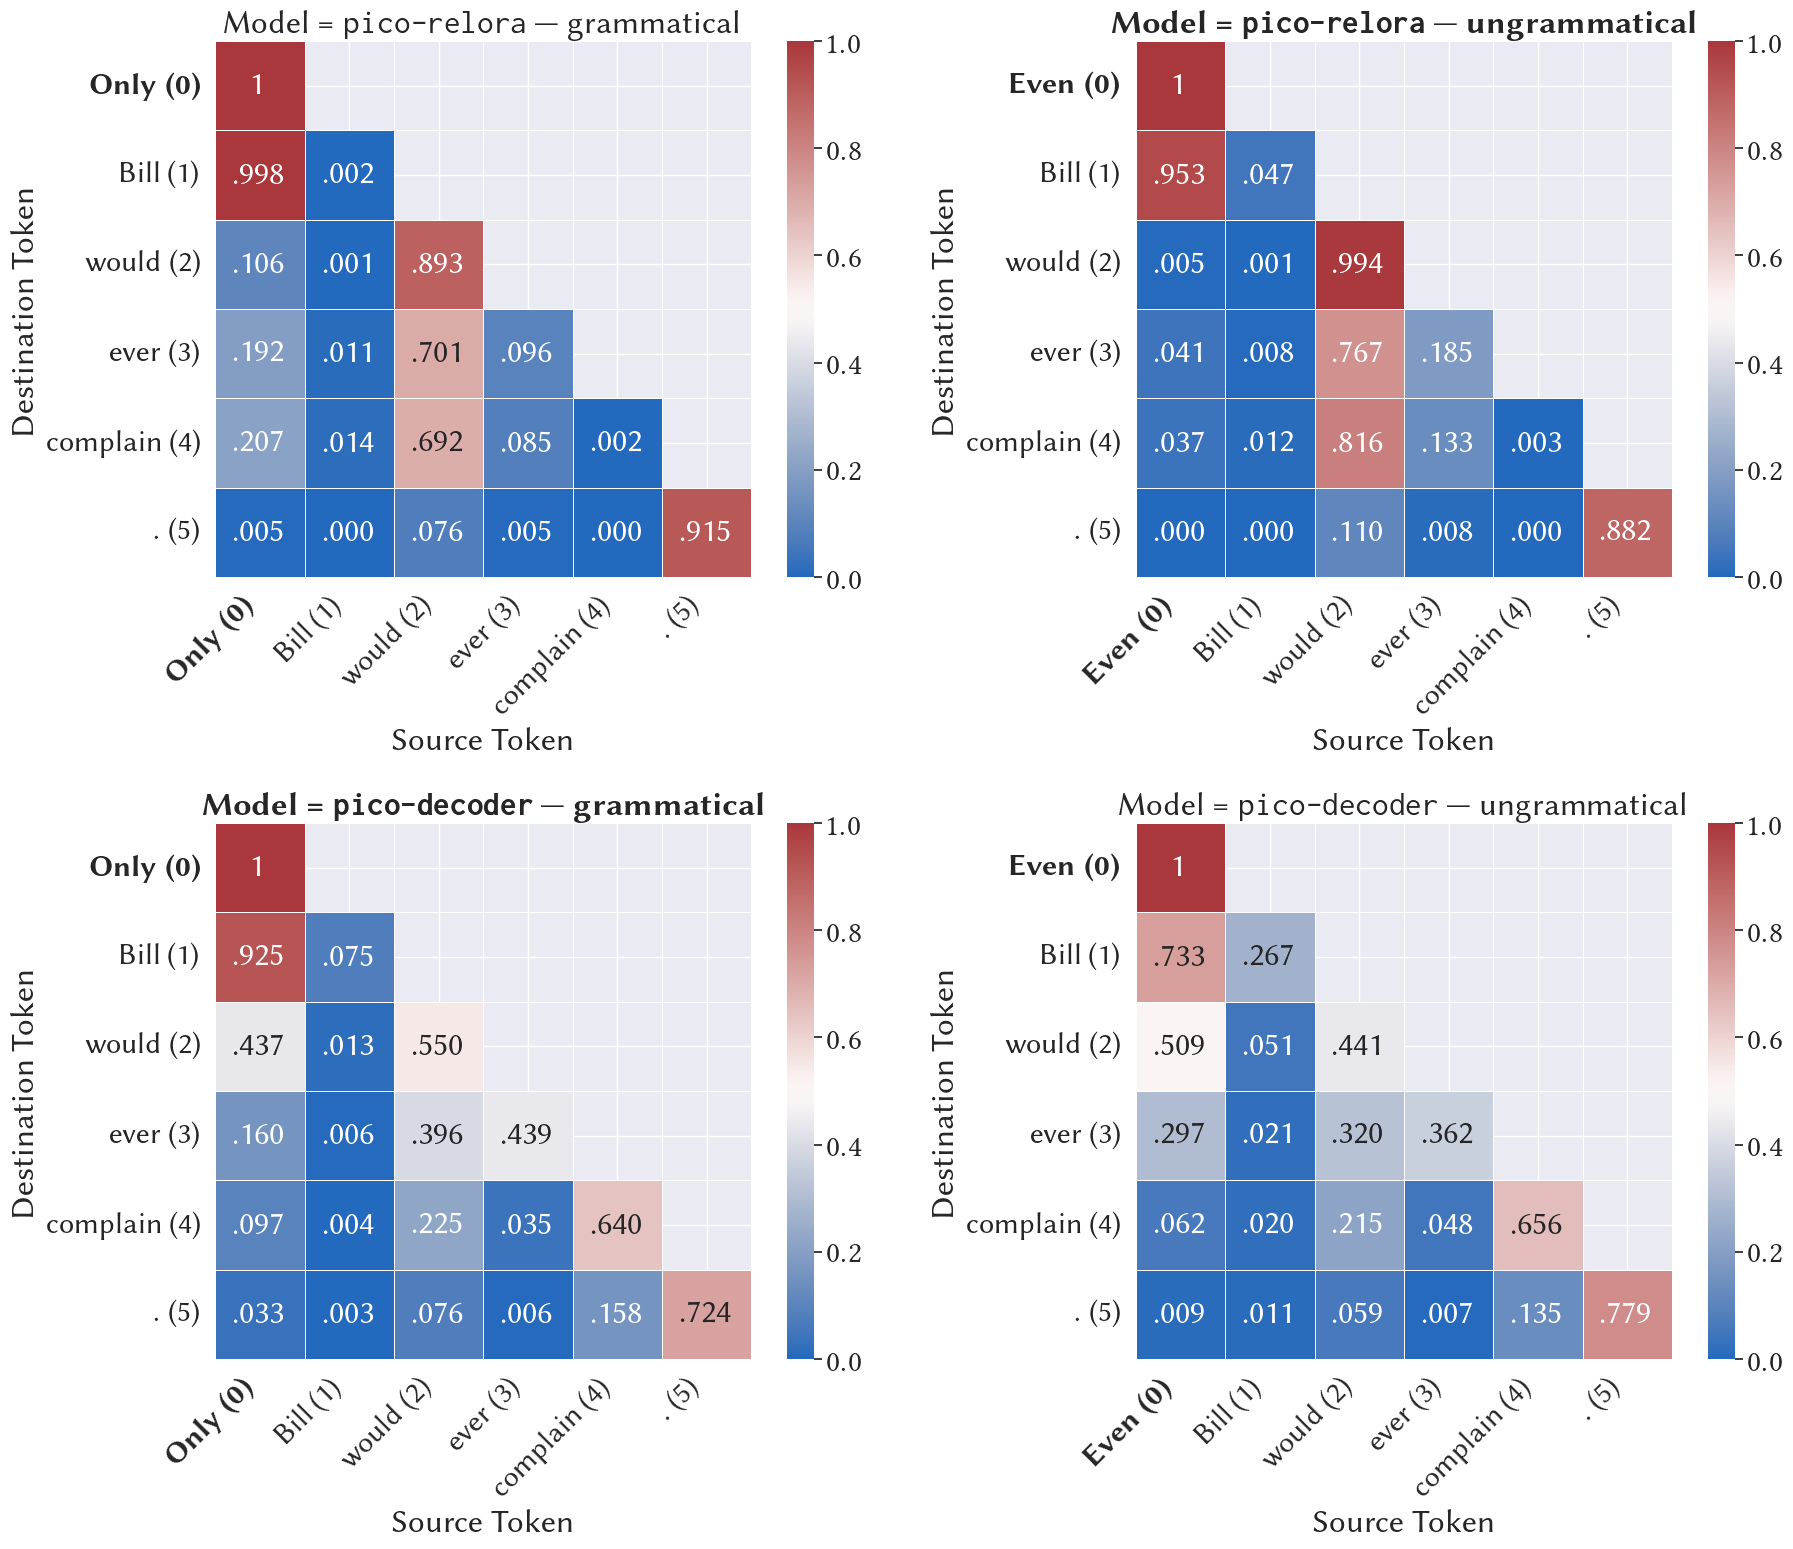

In [83]:
comparison_plot(
    sent_pair=0, layer=6, head=8, filename="npi-attn-score-l6h8", show_bar=True, height=8, font_scale=2
)